In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from gpflow.ci_utils import ci_niter

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

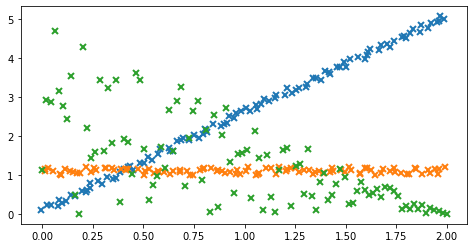

In [2]:
X1 = np.random.rand(100, 1)*2  # Observed locations for first output
X2 = np.random.rand(100, 1)*2   # Observed locations for second output
X3 = np.linspace(0,2,100)[:,None]
X1 = np.linspace(0,2,100)[:,None] + np.random.randn(*X1.shape) *0.01
X2 = np.linspace(0,2,100)[:,None] + np.random.randn(*X1.shape) *0.01
# Y1 = np.sin(6 * X1) + np.random.randn(*X1.shape) *0.3
# Y2 = np.sin(6 * X2) + np.random.randn(*X2.shape)*0.3
# Y3 = np.linspace(-5,5,100)[:,None] + np.random.randn(*X3.shape) 

Y1 = np.linspace(0,5,100)[:,None] + np.random.rand(*X1.shape)*0.2
Y2 = np.ones(100)[:,None]+np.random.rand(*X2.shape)*0.2
Y3 = np.linspace(5,0,100)[:,None]*np.random.rand(*X3.shape)


#print("lol",np.random.randn(*X3.shape))

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
_ = plt.plot(X2, Y2, "x", mew=2)
_ = plt.plot(X3, Y3, "x", mew=2)

# Augment the input with ones or zeros to indicate the required output dimension
X_aug1 = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))
X_augmented = np.vstack((X_aug1,np.hstack((X3, np.ones_like(X3)*2))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_aug1 = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))
Y_augmented = np.vstack((Y_aug1,np.hstack((Y3, np.ones_like(Y3)*2))))


(100,)
[ 0.07172479 -0.23316001  0.19805879  2.50127235  0.08168209]


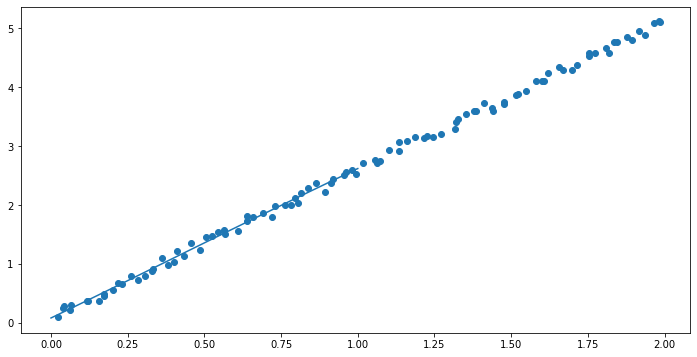

array([0.08168209, 0.10696744, 0.13229177, 0.15765367, 0.18305174,
       0.20848461, 0.23395091, 0.2594493 , 0.28497845, 0.31053706,
       0.33612383, 0.36173751, 0.38737682, 0.41304054, 0.43872745,
       0.46443635, 0.49016606, 0.5159154 , 0.54168325, 0.56746846,
       0.59326993, 0.61908657, 0.6449173 , 0.67076106, 0.69661682,
       0.72248356, 0.74836027, 0.77424597, 0.80013968, 0.82604048,
       0.85194741, 0.87785957, 0.90377606, 0.92969601, 0.95561855,
       0.98154285, 1.00746808, 1.03339344, 1.05931813, 1.08524139,
       1.11116247, 1.13708063, 1.16299516, 1.18890536, 1.21481054,
       1.24071005, 1.26660324, 1.29248948, 1.31836817, 1.34423872,
       1.37010055, 1.39595311, 1.42179586, 1.44762829, 1.47344988,
       1.49926017, 1.52505867, 1.55084496, 1.57661859, 1.60237916,
       1.62812626, 1.65385954, 1.67957863, 1.70528318, 1.73097288,
       1.75664743, 1.78230653, 1.80794993, 1.83357736, 1.8591886 ,
       1.88478343, 1.91036166, 1.93592311, 1.96146762, 1.98699

In [157]:
print(X1[:,0].shape)
mymodel = np.poly1d(np.polyfit(X1[:,0], Y1[:,0], 4))
print(np.polyfit(X1[:,0], Y1[:,0], 4))
myline = np.linspace(0, 1, 100)

plt.scatter(X1[:,0], Y1[:,0])
plt.plot(myline, mymodel(myline))
plt.show() 
mymodel(myline)

In [158]:
output_dim = 3  # Number of outputs
rank = 3  # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg

In [159]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

      fun: -145.41737257393254
 hess_inv: <45467x45467 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.07591554, -0.11058639, -0.08252753, ..., -0.00120813,
       -0.001959  , -0.0018812 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 11217
      nit: 10000
     njev: 11217
   status: 1
  success: False
        x: array([25.50037815,  5.15112971,  4.57517569, ..., -0.04210287,
       -0.04202135,  0.98220005])

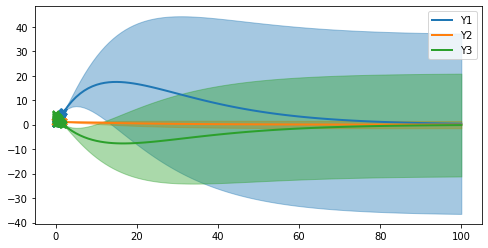

In [168]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(0, 100, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")
    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")


    (line,) = plt.plot(X3, Y3, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest)*2)))
    plot_gp(Xtest, mu, var, line.get_color(), "Y3")

    plt.legend()


plot(m)



[65.86551262  0.10694964 21.411272  ]
B = [[ 65.86551262  -0.77712737 -36.56117922]
 [ -0.77712737   0.10694964   0.45245521]
 [-36.56117922   0.45245521  21.411272  ]]


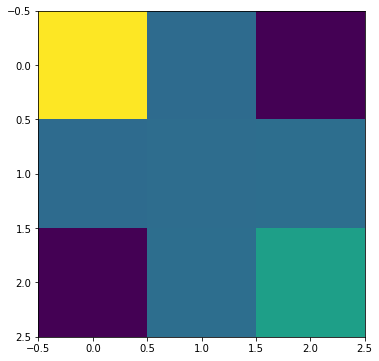

In [161]:
B = coreg.output_covariance().numpy()
var = coreg.output_variance().numpy()
print(var)
print("B =", B)
_ = plt.imshow(B)
plt.show()

In [162]:
print(coreg.W)
print(coreg.kappa)

<Parameter: dtype=float64, shape=[3, 3], fn="identity", numpy=
array([[ 4.57517569,  4.57517569,  4.57517569],
       [-0.05661913, -0.05661913, -0.05661913],
       [-2.6637359 , -2.6637359 , -2.6637359 ]])>
<Parameter: dtype=float64, shape=[3], fn="softplus", numpy=array([3.0688147 , 0.09733246, 0.12480519])>


In [8]:
n_samples, N_test, D, nu = 100, 20, 3, 4
a = np.ones((n_samples, N_test, D, nu))*2
b = tf.convert_to_tensor(a)
b =tf.reduce_sum(b, axis = 3)
print(b.shape)
print(b)

(100, 20, 3)
tf.Tensor(
[[[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]

 [[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]

 [[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]

 ...

 [[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]

 [[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]

 [[8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]
  ...
  [8. 8. 8.]
  [8. 8. 8.]
  [8. 8. 8.]]], shape=(100, 20, 3), dtype=float64)


# prullenbak


In [ ]:
print(Sigma_true)
means = np.zeros((100,3))
variances = np.zeros((100,3))
for an in range(Sigma_true.shape[0]):
    ananas = np.random.multivariate_normal([0,0,0], Sigma_true[an,:,:],size = 5000).T
    pine = tf.reduce_mean(ananas, axis = 1).numpy()
    apple = tf.math.reduce_variance(ananas, axis=1).numpy()
    means[an,:] = pine
    variances[an,:]= apple
def plot_gp(x, mu, var, color, label):
    print("x",x.shape)
    print("mu", mu.shape)
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(Xtest, mus, vs, X, Y):
    plt.figure(figsize=(20, 10))
    for i, (mu, var) in enumerate(zip(mus, vs)):
        (line,) = plt.plot(X[:,i], Y[:,i], "x", mew=2)
        label = "output " + str(i)
        plot_gp( Xtest, mu, var ,line.get_color(), label)
    plt.legend()

Xtest = np.linspace(0,4,100)[:,None]
mus = []
vs=  []

plot(Xtest, np.reshape(means, (3,100,1)), np.reshape(variances,(3,100,1)), X , Y)
#the shapes (100, 1), (100, 1), (100, 1), (100, 3), Y(100, 3)


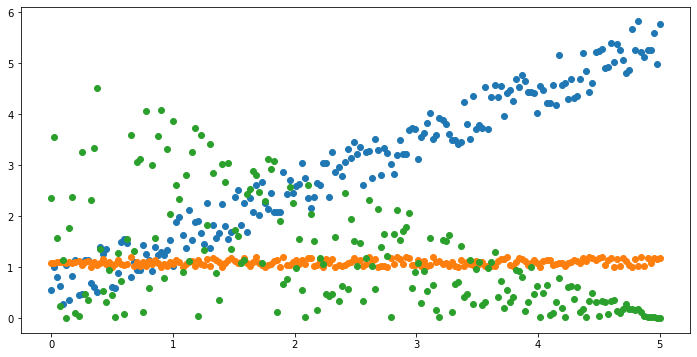

(200, 3)


In [5]:
X = np.linspace(0,5,200)
Y = np.array([np.linspace(0,5,200)+np.random.rand(200),np.ones(200)+np.random.rand(200)*0.2,np.linspace(5,0,200)*np.random.rand(200)])
Y = Y.T
plt.scatter(X, Y[:,0])
plt.scatter(X, Y[:,1])
plt.scatter(X, Y[:,2])
plt.show()
print(Y.shape)

In [24]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 

import numpy as np
import pandas as pd
from rpy2.robjects.conversion import localconverter

df = pd.DataFrame(Y, columns = ['Column_A','Column_B','Column_C'])
pd_rets = pd.DataFrame(df)

# compute DCC-Garch in R using rmgarch package
pandas2ri.activate()
with localconverter(ro.default_converter + pandas2ri.converter):
    r_rets = ro.conversion.py2rpy(pd_rets)
 # convert the daily returns from pandas dataframe in Python to dataframe in R
r_dccgarch_code = """
                library('rmgarch')
                function(r_rets, n_days){
                        univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                                                    variance.model = list(garchOrder = c(1,1),
                                                                        variance.targeting = FALSE, 
                                                                        model = "sGARCH"),
                                                    distribution.model = "norm")
                        n <- dim(r_rets)[2]
                        dcc_spec <- dccspec(uspec = multispec(replicate(n, univariate_spec)),
                                            dccOrder = c(1,1),
                                            distribution = "mvnorm")
                        gogarch_spec <-gogarchspec(mean.model = list(model = 'VAR', lag = 2), distribution.model = 'mvnorm', ica = 'fastica')

                        dcc_fit <- dccfit(dcc_spec, data=r_rets)
                        go_fit <- gogarchfit(gogarch_spec, data = r_rets, solver = 'hybrid', gfun = 'tanh', maxiter1 = 40000, epsilon = 1e-08, rseed = 100)

                        show(dcc_fit)
                        show(go_fit)
                        forecasts <- dccforecast(dcc_fit, n.ahead = n_days)
                        covariances = rcov(go_fit)
                        var = go_fit@model[["varcoef"]]
                        cof = coef(go_fit)
                        list(go_fit, forecasts@mforecast$H, covariances,go_fit,cof )
                }
                """
r_dccgarch = ro.r(r_dccgarch_code)
n_days= 4
r_res = r_dccgarch(r_rets,n_days)

pandas2ri.deactivate()
# end of R

r_dccgarch_model = r_res[0] # model parameters

r_forecast_cov = r_res[1] # forecasted covariance matrices for n_days

r_cov = r_res[2] # the covarince matrices for known points
garch_model = r_res[3]
coef = r_res[4]
# access and transform the covariance matrices in R format
n_cols = pd_rets.shape[1] # get the number of stocks in pd_rets
n_elements = n_cols*n_cols # the number of elements in each covariance matrix
n_matrix = int(len(r_forecast_cov[0])/(n_elements))
print(n_matrix) # this should be equal to n_days

# sum the daily forecasted covariance matrices 
cov_matrix = 0
for i in range(n_matrix):
    i_matrix = np.array([v for v in r_forecast_cov[0][i*n_elements:(i+1)*n_elements]])
    i_matrix = i_matrix.reshape(n_cols,n_cols)    
    cov_matrix += i_matrix


No convergence after 40000 steps

*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  17
[VAR GARCH DCC UncQ] : [0+12+2+3]
No. Series           :  3
No. Obs.             :  200
Log-Likelihood       :  -231.9589
Av.Log-Likelihood    :  -1.16 

Optimal Parameters
-----------------------------------
                   Estimate  Std. Error   t value Pr(>|t|)
[Column_A].mu      3.102800    0.106901  29.02499 0.000000
[Column_A].omega   0.011127    0.007681   1.44870 0.147422
[Column_A].alpha1  0.292407    0.049591   5.89633 0.000000
[Column_A].beta1   0.705377    0.050671  13.92081 0.000000
[Column_B].mu      1.088551    0.003850 282.71434 0.000000
[Column_B].omega   0.000237    0.000167   1.41866 0.155998
[Column_B].alpha1  0.085105    0.044637   1.90660 0.056572
[Column_B].beta1   0.852032    0.071614  11.89753 0.000000
[Column_C].mu      0.53295

In [28]:
print(coef)
print(var)
print(garch_model)
#transform the r object ino a numpy array
N = 100
D = 3
mgarch_sigma = np.zeros((N,D,D))
for i in range(N*D*D):
    mgarch_sigma[i//(D*D),(i%(D*D))//D, (i%(D*D))%D]= r_cov[i]


                F_1          F_2          F_3
omega  5.319312e-09 4.407089e-05 3.013426e-05
alpha1 7.892723e-02 6.117783e-02 7.894301e-07
beta1  9.061602e-01 9.284820e-01 9.983575e-01

          Column_A.l1   Column_B.l1 Column_C.l1     const
Column_A  0.979057542 -0.3934768556 0.033198452 0.4773427
Column_B  0.009295405 -0.0604001466 0.006891492 1.1199194
Column_C -0.356301342  0.0005686673 0.119835543 2.1117591


*------------------------------*
*        GO-GARCH Fit          *
*------------------------------*

Mean Model		: VAR
(Lag)			: 2
(Robust)		: FALSE
GARCH Model		: sGARCH
Distribution	: mvnorm
ICA Method		: fastica
No. Factors		: 3
No. Periods		: 200
Log-Likelihood	: -309.63
------------------------------------

U (rotation matrix) : 

        [,1]    [,2]    [,3]
[1,]  1.0939 -0.2622 -0.0635
[2,] -0.0213 -0.0390  0.0187
[3,] -0.0107 -0.0821 -0.1114

A (mixing matrix) : 

         [,1]     [,2]     [,3]
[1,] -0.12790  0.01522  0.01357
[2,] -0.00753 -0.00305 -0.00591
[3,]  0.9

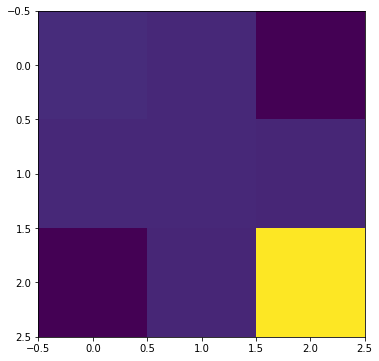

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 2.96784667e-02,  1.74010536e-03, -2.31253537e-01],
       [ 1.74010536e-03,  1.04478937e-04, -1.35119603e-02],
       [-2.31253537e-01, -1.35119603e-02,  1.80358017e+00]])>

In [16]:
avg_mgarch = tf.reduce_mean(mgarch_sigma, axis = 0)
_ = plt.imshow(avg_mgarch)
plt.show()
avg_mgarch

In [17]:
print(var)

          Column_A.l1   Column_B.l1 Column_C.l1     const
Column_A  0.979057542 -0.3934768556 0.033198452 0.4773427
Column_B  0.009295405 -0.0604001466 0.006891492 1.1199194
Column_C -0.356301342  0.0005686673 0.119835543 2.1117591

